# Multi-Objective Capacitated VRP (MOVRP) Problem Using Multi-Objective Evolutionary Algorithms (MOEAs)

### Global Function

Global function that is used by both algorithms for reading the files. 

In [124]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import os


def parse_vrp_file(file_path):
    """
    Parse a Vehicle Routing Problem (VRP) files.
    
    This function reads and parses VRP files containing problem instances with:
    - Problem metadata (name, type, dimension, capacity, etc.)
    - Node coordinates in 2D Euclidean space
    - Customer demand values
    - Depot location(s)
    
    Args:
        file_path (str): Path to the VRP file to be parsed
        
    Returns:
        dict: A dictionary containing parsed VRP data with keys:
            - 'metadata': Dictionary of problem metadata (name, capacity, etc.)
            - 'coords': List of (x, y) coordinate tuples, 0-based indexing
            - 'demands': List of demand values for each node, 0-based indexing
            - 'depots': List of depot indices, 0-based indexing
            - 'dist_matrix': 2D numpy array of Euclidean distances between all nodes
    """
    with open(file_path, 'r') as f: 
        lines = f.readlines()  # Read all lines into memory

    # Strip whitespace and filter empty lines for clean parsing
    lines = [line.strip() for line in lines if line.strip()]

    metadata = {}  # Dictionary to store problem metadata
    i = 0  # Line index counter for sequential parsing
    
    # Continue parsing metadata until we reach the coordinates section
    while not lines[i].startswith('NODE_COORD_SECTION'):
        if ':' in lines[i]:  # Check if line contains metadata key-value pair
            key, value = lines[i].split(':', 1)  # Split on first colon only
            metadata[key.strip()] = value.strip().strip('"')  # Store cleaned key-value pair
        i += 1  # Move to next line

    coords = []  # List to store (x, y) coordinate tuples
    i += 1  # Skip the 'NODE_COORD_SECTION' header line
    
    # Parse coordinates until we reach the demand section
    while not lines[i].startswith('DEMAND_SECTION'):
        parts = lines[i].split()  # Split line into components
        if len(parts) == 3:  # Valid coordinate line: node_id x y
            node_id = int(parts[0]) - 1  # Convert to 0-based indexing
            x, y = int(parts[1]), int(parts[2])  # Extract coordinates
            
            # Ensure coords list is large enough for this node_id
            while len(coords) <= node_id:
                coords.append(None)  # Fill with None placeholders
            coords[node_id] = (x, y)  # Store coordinate tuple at correct index
        i += 1  # Move to next line

    # Parse customer demands (convert from 1-based to 0-based indexing)
    demands = []  # List to store demand values for each node
    i += 1  # Skip the 'DEMAND_SECTION' header line
    
    # Parse demands until we reach the depot section
    while not lines[i].startswith('DEPOT_SECTION'):
        parts = lines[i].split()  # Split line into components
        if len(parts) == 2:  # Valid demand line: node_id demand_value
            node_id = int(parts[0]) - 1  # Convert to 0-based indexing
            demand = int(parts[1])  # Extract demand value
            
            # Ensure demands list is large enough for this node_id
            while len(demands) <= node_id:
                demands.append(None)  # Fill with None placeholders
            demands[node_id] = demand  # Store demand at correct index
        i += 1  # Move to next line

    # Parse depot locations (convert from 1-based to 0-based indexing)
    depots = []  # List to store depot node indices
    i += 1  # Skip the 'DEPOT_SECTION' header line
    
    # Parse depot indices until EOF or -1 terminator
    while i < len(lines) and lines[i] != 'EOF':
        depot = int(lines[i])  # Parse depot node number
        if depot == -1:  # -1 indicates end of depot list
            break
        depots.append(depot - 1)  # Convert to 0-based and store
        i += 1  # Move to next line

    # Compute Euclidean distance matrix for all node pairs
    dimension = int(metadata.get('DIMENSION', len(coords)))  # Get problem dimension
    dist_matrix = np.zeros((dimension, dimension))  # Initialize distance matrix
    
    # Calculate pairwise distances using Euclidean formula
    for a in range(dimension):  # For each node a
        for b in range(dimension):  # For each node b
            x1, y1 = coords[a]  # Get coordinates of node a
            x2, y2 = coords[b]  # Get coordinates of node b
            # Calculate Euclidean distance: sqrt((x2-x1)² + (y2-y1)²)
            dist_matrix[a][b] = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    # Return structured data dictionary
    return {
        'metadata': metadata,  # Problem metadata (capacity, name, etc.)
        'coords': coords,  # List of (x, y) tuples, 0-based (index 0 = node 1)
        'demands': demands,  # List of demand integers, 0-based
        'depots': depots,  # List of depot indices, 0-based (usually [0] for depot at node 1)
        'dist_matrix': dist_matrix  # 2D numpy array of Euclidean distances
    }

## NSGA-II Implementation

In [125]:
class NSGAII:
    """
    Non-dominated Sorting Genetic Algorithm II (NSGA-II) for Multi-Objective Vehicle Routing Problem.
    
    NSGA-II is a multi-objective evolutionary algorithm that uses non-dominated sorting and 
    crowding distance to maintain diversity in the Pareto front. This implementation is 
    specifically designed for the Capacitated Vehicle Routing Problem (CVRP) with two objectives:
    1. Minimize total distance traveled by all vehicles
    2. Minimize route imbalance (standard deviation of route lengths)
    
    The algorithm uses a permutation-based representation where each individual represents
    a sequence of customers that is then split into feasible routes using capacity constraints.
    Uses insert mutation which is particularly effective for VRP problems.
    
    Attributes:
        data (dict): Parsed VRP problem data containing coordinates, demands, distance matrix
        pop_size (int): Population size for the evolutionary algorithm
        generations (int): Number of generations to evolve
        crossover_rate (float): Probability of crossover operation
        mutation_rate (float): Probability of mutation operation
        population (list): Current population of individuals
    """
    
    def __init__(self, data, pop_size=20, generations=10, crossover_rate=0.7, mutation_rate=0.2):
        """
        Initialize NSGA-II algorithm with problem data and parameters.
        
        Args:
            data (dict): VRP problem data from parse_vrp_file()
            pop_size (int, optional): Population size. Defaults to 20.
            generations (int, optional): Number of generations. Defaults to 10.
            crossover_rate (float, optional): Crossover probability. Defaults to 0.7.
            mutation_rate (float, optional): Mutation probability. Defaults to 0.2.
        """
        self.data = data  # Store problem instance data
        self.pop_size = pop_size  # Number of individuals in population
        self.generations = generations  # Number of evolutionary generations
        self.crossover_rate = crossover_rate  # Probability of applying crossover
        self.mutation_rate = mutation_rate  # Probability of applying mutation
        self.population = []  # Initialize empty population

        # Pre-compute frequently accessed values for performance optimization
        self.dist_matrix = self.data['dist_matrix']  # Distance matrix between all nodes
        self.capacity = int(self.data['metadata']['CAPACITY'])  # Vehicle capacity constraint
        self.demands = self.data['demands']  # Customer demand values
        self.n_customers = len(self.data['coords']) - 1  # Number of customers (excluding depot)
        self.customer_range = list(range(1, self.n_customers + 1))  # Customer indices (1-based)

    def split_routes(self, customer_sequence):
        """
        Split a customer sequence into feasible routes using capacity constraints.
        
        This method implements the route-first, cluster-second approach where a giant tour
        of customers is split into multiple vehicle routes based on capacity limits.
        Each route starts and ends at the depot (node 0).
        
        Args:
            customer_sequence (list): Sequence of customer indices to visit
            
        Returns:
            list: List of routes, where each route is a list starting and ending with depot (0)
        """
        routes, route, load = [], [0], 0  # Initialize route list, current route, current load
        
        for customer in customer_sequence:  # Process each customer in sequence
            demand = self.demands[customer]  # Get customer's demand
            
            if load + demand > self.capacity:  # Check if adding customer exceeds capacity
                route.append(0)  # Close current route by returning to depot
                routes.append(route)  # Add completed route to route list
                route, load = [0, customer], demand  # Start new route with this customer
            else:
                route.append(customer)  # Add customer to current route
                load += demand  # Update current load
                
        route.append(0)  # Close final route by returning to depot
        routes.append(route)  # Add final route to route list
        return routes

    def calculate_route_distance(self, route):
        """
        Calculate the total distance for a single route.
        
        Args:
            route (list): Route as list of node indices
            
        Returns:
            float: Total distance traveled in this route
        """
        return sum(self.dist_matrix[route[i], route[i+1]] for i in range(len(route) - 1))

    def evaluate_individual(self, individual):
        """
        Evaluate an individual's fitness using two objectives for MOVRP.
        
        Args:
            individual (dict): Individual containing routes and other data
        """
        if individual['objectives'] is not None:  # Skip if already evaluated
            return
            
        routes = individual['routes']  # Get individual's route structure
        route_distances = [self.calculate_route_distance(route) for route in routes]  # Calculate each route's distance
        total_dist = sum(route_distances)  # Objective 1: Total distance
        
        if len(route_distances) > 1:  # Calculate balance only if multiple routes
            mean_length = total_dist / len(route_distances)  # Average route length
            variance = sum((d - mean_length)**2 for d in route_distances) / len(route_distances)  # Variance calculation
            route_balance = variance**0.5  # Objective 2: Standard deviation (route imbalance)
        else:
            route_balance = 0.0  # Single route has perfect balance
            
        individual['objectives'] = [total_dist, route_balance]  # Store both objectives

    def evaluate_population(self, population):
        """
        Evaluate fitness for all individuals in the population.
        
        Args:
            population (list): List of individuals to evaluate
        """
        for individual in population:  # Process each individual
            self.evaluate_individual(individual)  # Calculate objectives

    def generate_initial_population(self):
        """
        Generate initial population using heuristics and random solutions.
        
        Returns:
            list: Initial population of individuals
        """
        population = []  # Initialize empty population
        
        # Add heuristic solutions for better starting points if population size allows
        if self.pop_size >= 2:
            nn_seq = self.nearest_neighbor_solution()  # Distance-optimized solution
            population.append(self.create_individual(nn_seq))  # Add to population
            
            bal_seq = self.balanced_insertion_solution()  # Balance-optimized solution
            population.append(self.create_individual(bal_seq))  # Add to population
            
            # Fill remaining population with random permutations
            for _ in range(self.pop_size - 2):
                perm = self.customer_range[:]  # Copy customer list
                random.shuffle(perm)  # Random permutation
                population.append(self.create_individual(perm))  # Add to population
        else:
            # If population size is small, use only random solutions
            for _ in range(self.pop_size):
                perm = self.customer_range[:]  # Copy customer list
                random.shuffle(perm)  # Random permutation
                population.append(self.create_individual(perm))  # Add to population
                
        return population

    def nearest_neighbor_solution(self):
        """
        Generate a distance-optimized solution using nearest neighbor heuristic.
        
        Returns:
            list: Customer sequence optimized for minimal total distance
        """
        unvisited = set(self.customer_range)  # Set of unvisited customers
        solution = []  # Customer sequence being built
        current = 0  # Start from depot
        
        while unvisited:  # Continue until all customers visited
            # Calculate distances from current location to all unvisited customers
            distances = [(self.dist_matrix[current, customer], customer)
                        for customer in unvisited]
            _, next_customer = min(distances)  # Select nearest customer
            solution.append(next_customer)  # Add to sequence
            unvisited.remove(next_customer)  # Mark as visited
            current = next_customer  # Move to selected customer
            
        return solution

    def balanced_insertion_solution(self):
        """
        Generate a balance-focused solution using distance-based alternating insertion.
        
        Returns:
            list: Customer sequence optimized for route balance
        """
        # Sort customers by distance from depot
        customers_by_distance = [(self.dist_matrix[0, c], c) for c in self.customer_range]
        customers_by_distance.sort()  # Sort by increasing distance
        
        solution = []  # Initialize solution sequence
        # Split into near and far customers
        near = [c for _, c in customers_by_distance[:len(customers_by_distance)//2]]
        far = [c for _, c in customers_by_distance[len(customers_by_distance)//2:]]
        
        # Alternate between near and far customers for balance
        for i in range(max(len(near), len(far))):
            if i < len(near):  # Add near customer if available
                solution.append(near[i])
            if i < len(far):  # Add far customer if available
                solution.append(far[i])
                
        return solution

    def fast_non_dominated_sort(self, population):
        """
        Perform non-dominated sorting to rank individuals by Pareto dominance.
        
        Args:
            population (list): Population to sort and rank
        """
        n = len(population)  # Population size
        objectives = [ind['objectives'] for ind in population]  # Extract objective values
        domination_count = [0] * n  # Count of solutions that dominate each individual
        dominated_solutions = [[] for _ in range(n)]  # Lists of solutions dominated by each individual
        
        # Compare all pairs to determine dominance relationships
        for i in range(n):
            obj1_i, obj2_i = objectives[i]  # Objectives of individual i
            for j in range(i + 1, n):  # Only check upper triangle to avoid duplicates
                obj1_j, obj2_j = objectives[j]  # Objectives of individual j
                
                # Check if i dominates j
                if (obj1_i <= obj1_j and obj2_i <= obj2_j) and (obj1_i < obj1_j or obj2_i < obj2_j):
                    dominated_solutions[i].append(j)  # i dominates j
                    domination_count[j] += 1  # j is dominated by one more solution
                # Check if j dominates i
                elif (obj1_j <= obj1_i and obj2_j <= obj2_i) and (obj1_j < obj1_i or obj2_j < obj2_i):
                    dominated_solutions[j].append(i)  # j dominates i
                    domination_count[i] += 1  # i is dominated by one more solution
        
        # Identify first front (non-dominated solutions)
        current_front = [i for i in range(n) if domination_count[i] == 0]
        rank = 1  # Start with rank 1
        
        # Assign rank 1 to non-dominated solutions
        for i in current_front:
            population[i]['rank'] = rank
        
        # Process remaining fronts iteratively
        while current_front:
            next_front = []  # Solutions for next rank level
            
            # For each solution in current front, reduce domination count of dominated solutions
            for i in current_front:
                for j in dominated_solutions[i]:  # For each solution dominated by i
                    domination_count[j] -= 1  # Reduce domination count
                    if domination_count[j] == 0:  # If no longer dominated
                        next_front.append(j)  # Add to next front
            
            if next_front:  # If there are solutions for next rank
                rank += 1  # Increment rank
                for i in next_front:  # Assign new rank
                    population[i]['rank'] = rank
                    
            current_front = next_front  # Move to next front

    def calculate_crowding_distance(self, population):
        """
        Calculate crowding distance for diversity preservation in NSGA-II.
        
        Args:
            population (list): Population with assigned ranks
        """
        # Initialize crowding distance to zero for all individuals
        for ind in population:
            ind['crowding_distance'] = 0.0
        
        # Group individuals by rank for separate processing
        rank_groups = {}
        for i, ind in enumerate(population):
            rank = ind['rank']  # Get individual's rank
            if rank not in rank_groups:
                rank_groups[rank] = []  # Initialize rank group
            rank_groups[rank].append(i)  # Add individual index to rank group
        
        # Process each rank separately
        for indices in rank_groups.values():
            n_front = len(indices)  # Number of solutions in this front
            
            # Special case: small fronts get infinite distance
            if n_front <= 2:
                for i in indices:
                    population[i]['crowding_distance'] = float('inf')
                continue
            
            # Calculate crowding distance for each objective
            for obj_idx in range(2):  # For both objectives
                # Sort solutions by current objective value
                indices.sort(key=lambda i: population[i]['objectives'][obj_idx])
                
                # Boundary solutions get infinite distance
                population[indices[0]]['crowding_distance'] = float('inf')  # Minimum
                population[indices[-1]]['crowding_distance'] = float('inf')  # Maximum
                
                # Calculate range of objective values in this front
                obj_range = population[indices[-1]]['objectives'][obj_idx] - population[indices[0]]['objectives'][obj_idx]
                
                if obj_range > 0:  # Avoid division by zero
                    # Calculate distance for interior solutions
                    for j in range(1, n_front - 1):
                        i = indices[j]  # Current solution index
                        
                        if population[i]['crowding_distance'] != float('inf'):
                            # Distance = normalized gap between neighbors
                            prev_obj = population[indices[j-1]]['objectives'][obj_idx]
                            next_obj = population[indices[j+1]]['objectives'][obj_idx]
                            population[i]['crowding_distance'] += (next_obj - prev_obj) / obj_range

    def tournament_selection(self, population, tournament_size=2):
        """
        Select parent using tournament selection based on NSGA-II criteria.
        
        Args:
            population (list): Population to select from
            tournament_size (int, optional): Number of individuals in tournament. Defaults to 2.
            
        Returns:
            dict: Selected individual for reproduction
        """
        tournament = random.sample(population, tournament_size)  # Random tournament
        # Select best: minimize rank, maximize crowding distance
        return min(tournament, key=lambda x: (x['rank'], -x['crowding_distance']))

    def create_individual(self, customer_sequence):
        """
        Create an individual from a customer sequence.
        
        Args:
            customer_sequence (list): Sequence of customer indices
            
        Returns:
            dict: Complete individual structure
        """
        return {
            'customer_sequence': customer_sequence,  # Permutation representation
            'routes': self.split_routes(customer_sequence),  # Convert to actual routes
            'objectives': None,  # Fitness values (calculated later)
            'rank': None,  # Dominance rank (assigned during sorting)
            'crowding_distance': 0.0  # Diversity measure (calculated later)
        }

    def pmx_crossover(self, parent1, parent2):
        """
        Perform Partially Mapped Crossover (PMX) for permutation representation.
        
        Args:
            parent1 (dict): First parent individual
            parent2 (dict): Second parent individual
            
        Returns:
            dict: Offspring individual created by crossover
        """
        size = len(parent1['customer_sequence'])  # Length of customer sequence
        p1, p2 = parent1['customer_sequence'], parent2['customer_sequence']  # Extract sequences
        
        if size < 2:  # Edge case: single customer
            return self.create_individual(p1[:])
        
        start, end = sorted(random.sample(range(size), 2))  # Random crossover segment
        child = [None] * size  # Initialize offspring
        
        # Copy crossover segment from parent1
        for i in range(start, end + 1):
            child[i] = p1[i]
        
        # Create mapping from conflicting elements in parent2 to parent1
        mapping = {p2[i]: p1[i] for i in range(start, end + 1) if p1[i] != p2[i]}
        
        # Fill remaining positions
        for i in range(size):
            if child[i] is None:  # Position needs to be filled
                gene = p2[i]  # Start with parent2's gene
                
                # Follow mapping chain to resolve conflicts
                while gene in mapping:
                    gene = mapping[gene]
                
                # Final conflict resolution: use available customer
                if gene in child:
                    available = set(self.customer_range) - set(g for g in child if g is not None)
                    gene = available.pop() if available else p2[i]
                
                child[i] = gene  # Assign resolved gene
        
        return self.create_individual(child)  # Create complete individual

    def insert_mutation(self, individual):
        """
        Apply insert mutation operator specifically designed for VRP optimization.
        
        Insert mutation removes a randomly selected customer from one position
        and inserts it at a different random position. This type of mutation
        is particularly effective for VRP problems because:
        - It preserves most of the tour structure while making meaningful changes
        - Often improves route efficiency by relocating customers
        - Provides good balance between exploration and exploitation
        
        Args:
            individual (dict): Individual to mutate
            
        Returns:
            dict: New individual after mutation (original unchanged)
            
        Example:
            Original: [1, 2, 3, 4, 5]
            Remove customer 3 from position 2, insert at position 0
            Result: [3, 1, 2, 4, 5]
        """
        seq = individual['customer_sequence'][:]  # Copy sequence to avoid modifying original
        
        if random.random() < self.mutation_rate:  # Apply mutation with given probability
            if len(seq) > 2:  # Need at least 3 customers for meaningful insert mutation
                i = random.randint(0, len(seq)-1)  # Source position (customer to move)
                j = random.randint(0, len(seq)-1)  # Target position (where to insert)
                
                if i != j:  # Only mutate if positions are different
                    gene = seq.pop(i)  # Remove customer from source position
                    seq.insert(j, gene)  # Insert customer at target position
        
        return self.create_individual(seq)  # Create new individual with mutated sequence

    def run(self):
        """
        Execute the main NSGA-II algorithm loop with insert mutation.
        
        Implements the complete NSGA-II procedure:
        1. Initialize population with heuristics and random solutions
        2. Evaluate initial population
        3. Perform non-dominated sorting and crowding distance calculation
        4. For each generation:
           - Create offspring through selection, crossover, and insert mutation
           - Evaluate offspring population
           - Combine parent and offspring populations
           - Perform environmental selection using NSGA-II criteria
           - Select best individuals for next generation
        
        Returns:
            list: Final population after evolution (Pareto front approximation)
        """
        # Phase 1: Initialize population
        self.population = self.generate_initial_population()  # Create initial population
        self.evaluate_population(self.population)  # Evaluate fitness
        self.fast_non_dominated_sort(self.population)  # Assign dominance ranks
        self.calculate_crowding_distance(self.population)  # Calculate diversity measure
        
        # Phase 2: Evolution loop
        for gen in range(1, self.generations + 1):  # For each generation
            offspring = []  # Initialize offspring population
            
            # Create offspring population
            for _ in range(self.pop_size):
                # Selection: Choose parents using tournament selection
                parent1 = self.tournament_selection(self.population)
                parent2 = self.tournament_selection(self.population)
                
                # Crossover: Create child with given probability
                if random.random() < self.crossover_rate:
                    child = self.pmx_crossover(parent1, parent2)  # PMX crossover
                else:
                    child = self.create_individual(parent1['customer_sequence'][:])  # Clone parent1
                
                # Mutation: Apply insert mutation operator
                child = self.insert_mutation(child)  # Use insert mutation instead of swap
                offspring.append(child)  # Add to offspring population
            
            # Evaluate new offspring
            self.evaluate_population(offspring)
            
            # Environmental selection: Combine and select best
            combined = self.population + offspring  # Combine parent and offspring (2*pop_size)
            self.fast_non_dominated_sort(combined)  # Rank all individuals
            self.calculate_crowding_distance(combined)  # Calculate diversity
            
            # Select best pop_size individuals for next generation
            combined.sort(key=lambda x: (x['rank'], -x['crowding_distance']))
            self.population = combined[:self.pop_size]  # Keep best individuals
        
        return self.population  # Return final Pareto front approximation

## SPEA2 Implementation

In [126]:
import random
import math
import numpy as np

class SPEA2():

    def __init__(self, data, pop_size=10, archive_size=10, generations=5, mutation_rate=0.3, crossover_rate=0.7):
        self.data = data
        self.pop_size = pop_size
        self.archive_size = archive_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate

        # Pre-cache frequently accessed values from data
        self.dist_matrix = self.data['dist_matrix']
        self.capacity = int(self.data['metadata']['CAPACITY'])
        self.demands = self.data['demands']
        self.n_customers = len(self.data['coords']) - 1
        self.customer_range = list(range(1, self.n_customers + 1))

    def nearest_neighbor_solution(self):
        """Distance-optimized solution"""
        unvisited = set(self.customer_range)
        solution = []
        current = 0
        while unvisited:
            distances = [(self.dist_matrix[current, customer], customer)
                        for customer in unvisited]
            _, next_customer = min(distances)
            solution.append(next_customer)
            unvisited.remove(next_customer)
            current = next_customer
        return solution

    def balanced_insertion_solution(self):
        """Balance-focused solution"""
        customers_by_distance = [(self.dist_matrix[0, c], c) for c in self.customer_range]
        customers_by_distance.sort()
        solution = []
        near = [c for _, c in customers_by_distance[:len(customers_by_distance)//2]]
        far = [c for _, c in customers_by_distance[len(customers_by_distance)//2:]]
        for i in range(max(len(near), len(far))):
            if i < len(near):
                solution.append(near[i])
            if i < len(far):
                solution.append(far[i])
        return solution
    
    def split_routes(self, customer_sequence):
        """Route splitting with capacity constraints"""
        routes, route, load = [], [0], 0
        for customer in customer_sequence:
            demand = self.demands[customer]
            if load + demand > self.capacity:
                route.append(0)
                routes.append(route)
                route, load = [0, customer], demand
            else:
                route.append(customer)
                load += demand
        route.append(0)
        routes.append(route)
        return routes

    def calculate_route_distance(self, route):
        """Calculate distance for a single route"""
        return sum(self.dist_matrix[route[i], route[i+1]] for i in range(len(route) - 1))

    def evaluate_individual(self, individual):
        """Assignment-compliant: Total Distance vs Standard Deviation"""
        if individual['objectives'] is not None:
            return
        routes = individual['routes']
        route_distances = [self.calculate_route_distance(route) for route in routes]
        total_dist = sum(route_distances)
        if len(route_distances) > 1:
            mean_length = total_dist / len(route_distances)
            variance = sum((d - mean_length)**2 for d in route_distances) / len(route_distances)
            route_balance = variance**0.5  # Standard deviation
        else:
            route_balance = 0.0
        individual['objectives'] = [total_dist, route_balance]

    def evaluate_population(self, population):
        for individual in population:
            self.evaluate_individual(individual)
            
    def create_individual(self, customer_sequence):
        """Out of a random sequence of customer visits, applies constraints to it"""
        return {
            'customer_sequence': customer_sequence,  # A random customer sequence
            'routes': self.split_routes(customer_sequence),  # Applies constraints
            'objectives': None,  # Where the evaluation of the route is stored
        }
    
    def domination_function(self, indiv_1, indiv_2):
        """Checks if indiv_1 weakly dominates indiv_2 in objective space, works only with 2 objectives to optimize"""
        x_1, y_1 = indiv_1['objectives']  # Retrieve Objectives from indiv_1
        x_2, y_2 = indiv_2['objectives']  # Retrieve Objectives from indiv_2

        if (x_1 <= x_2 and y_1 <= y_2):  # Check for weak domination by seeing if objectives are better or equal
            return True  # If True return True // indiv_1 weakly dominates indiv_2
        else:
            return False  # If False return False // indiv_1 does not dominate indiv_2

    def raw_fitness_function(self, population):
        """Calculates the raw fitness value of each individual in the population"""
        strength = np.zeros(len(population))  # Initialize array for strength values, 1 for each indiv
        raw_fitness = np.zeros(len(population))  # FIXED: Initialize with zeros instead of ones
        
        # Calculate strength values
        for i in range(len(population)):  # Iterate through population
            for j in range(len(population)):  # Iterate through population
                if i != j:  # If not the same individual
                    if self.domination_function(population[i], population[j]):  # If i weakly dominates j
                        strength[i] += 1  # Increase strength of i by one
        
        # Calculate raw fitness values
        for i in range(len(population)):  # Iterate through population
            for j in range(len(population)):  # Iterate through population
                if i != j:  # If not the same individual
                    if self.domination_function(population[j], population[i]):  # If j weakly dominates i
                        raw_fitness[i] += strength[j]  # Add the strength of j to raw fitness value for i
                        
        return raw_fitness

    def euclidean_distance(self, p1, p2):
        x_1, y_1 = p1
        x_2, y_2 = p2
        return np.sqrt((x_2 - x_1)**2 + (y_2 - y_1)**2)
    
    def density_measure_function(self, population):
        """FIXED: Density measure function to avoid index out of bounds"""
        pop_size = len(population)
        if pop_size <= 2:
            # For very small populations, return zero density
            return np.zeros(pop_size)
            
        distances = np.zeros((pop_size, pop_size))
        
        # Calculate distance matrix
        for i in range(pop_size):
            indiv_1 = population[i]
            for j in range(pop_size):
                indiv_2 = population[j]
                distances[i, j] = self.euclidean_distance(indiv_1['objectives'], indiv_2['objectives'])
        
        # Sort distances for each individual
        distances = np.sort(distances, axis=1)
        
        # Calculate k-th nearest neighbor distance (k should be valid index)
        k = max(1, min(int(np.sqrt(pop_size)), pop_size - 1))  # FIXED: Ensure k is valid
        
        density_measure = []
        for i in range(pop_size):
            # Use k-th nearest neighbor distance (skip distance 0 to self)
            kth_distance = distances[i, k] if k < pop_size else distances[i, -1]
            density_measure.append(1.0 / (2.0 + kth_distance))  # FIXED: Proper formula
        
        return np.array(density_measure)
    
    def fitness_function(self, population):
        raw_fitness = self.raw_fitness_function(population)
        density_measure = self.density_measure_function(population)
        fitness = raw_fitness + density_measure
        return fitness

    def sort_by_fitness(self, population, fitness):
        idx = np.argsort(fitness)
        new_population = []
        new_fitness = []
        for i in range(len(idx)):
            new_population.append(population[idx[i]])
            new_fitness.append(fitness[idx[i]])
        return new_population, np.array(new_fitness)

    def roulette_wheel(self, fitness_vals):
        """FIXED: Proper roulette wheel selection for minimization problems"""
        if len(fitness_vals) == 0:
            return 0
            
        # Convert fitness to selection probabilities (lower fitness = higher probability)
        min_fitness = np.min(fitness_vals)
        adjusted_fitness = fitness_vals - min_fitness + 1e-10  # Avoid division by zero
        probabilities = 1.0 / (adjusted_fitness + 1e-10)  # Invert for minimization
        probabilities = probabilities / np.sum(probabilities)  # Normalize
        
        # Cumulative probabilities
        cumsum = np.cumsum(probabilities)
        
        # Select individual
        random_val = np.random.rand()
        for i in range(len(cumsum)):
            if random_val <= cumsum[i]:
                return i
        return len(cumsum) - 1  # Fallback to last individual

    def pmx_crossover(self, parent1, parent2):
        """PMX crossover"""
        size = len(parent1['customer_sequence'])
        p1, p2 = parent1['customer_sequence'], parent2['customer_sequence']
        if size < 2:
            return self.create_individual(p1[:])
        start, end = sorted(random.sample(range(size), 2))
        child = [None] * size
        for i in range(start, end + 1):
            child[i] = p1[i]
        mapping = {p2[i]: p1[i] for i in range(start, end + 1) if p1[i] != p2[i]}
        for i in range(size):
            if child[i] is None:
                gene = p2[i]
                while gene in mapping:
                    gene = mapping[gene]
                if gene in child:
                    available = set(self.customer_range) - set(g for g in child if g is not None)
                    gene = available.pop() if available else p2[i]
                child[i] = gene
        return self.create_individual(child)

    def swap_mutation(self, individual):
        seq = individual['customer_sequence'][:]
        if random.random() < self.mutation_rate:
            mutation_type = random.choice(['swap', 'insert', 'reverse'])
            if mutation_type == 'swap' and len(seq) > 1:
                i, j = random.sample(range(len(seq)), 2)
                seq[i], seq[j] = seq[j], seq[i]
            elif mutation_type == 'insert' and len(seq) > 2:
                i = random.randint(0, len(seq)-1)
                j = random.randint(0, len(seq)-1)
                if i != j:
                    gene = seq.pop(i)
                    seq.insert(j, gene)
            elif mutation_type == 'reverse' and len(seq) > 2:
                i, j = sorted(random.sample(range(len(seq)), 2))
                seq[i:j+1] = reversed(seq[i:j+1])
        return self.create_individual(seq)
    
    def breeding(self, population, fitness):
        """FIXED: Proper breeding with bounds checking"""
        offspring = []
        for i in range(self.pop_size):
            parent1_idx = self.roulette_wheel(fitness)
            parent2_idx = self.roulette_wheel(fitness)
            
            # Ensure different parents with bounds checking
            attempts = 0
            while parent1_idx == parent2_idx and attempts < 10:
                parent2_idx = self.roulette_wheel(fitness)
                attempts += 1
                
            parent1, parent2 = population[parent1_idx], population[parent2_idx]
            
            if random.random() < self.crossover_rate:
                child = self.pmx_crossover(parent1, parent2)
            else:
                child = self.create_individual(parent1['customer_sequence'][:])
            child = self.swap_mutation(child)
            offspring.append(child)
        return offspring
            
    def generate_initial_population(self):
        population = []
        # Add 2 heuristic solutions for better starting points
        if self.pop_size >= 2:
            nn_seq = self.nearest_neighbor_solution()
            population.append(self.create_individual(nn_seq))
            bal_seq = self.balanced_insertion_solution()
            population.append(self.create_individual(bal_seq))
            for _ in range(self.pop_size - 2):
                perm = self.customer_range[:]
                random.shuffle(perm)
                population.append(self.create_individual(perm))
        else:
            for _ in range(self.pop_size):
                perm = self.customer_range[:]
                random.shuffle(perm)
                population.append(self.create_individual(perm))
        return population

    def run(self):
        """FIXED: Main algorithm loop with proper copying and flow"""
        # Initialize population and archive
        self.population = self.generate_initial_population()
        self.evaluate_population(self.population)
        
        # Initialize archive with copy of initial population
        self.archive = [ind.copy() for ind in self.population]  # FIXED: Proper copying
        
        for generation in range(self.generations):  # FIXED: Proper loop structure
            # Combine population and archive
            combined_population = self.population + self.archive
            
            # Calculate fitness
            fitness = self.fitness_function(combined_population)
            
            # Sort by fitness (lower is better)
            combined_population, fitness = self.sort_by_fitness(combined_population, fitness)
            
            # Update archive (best individuals)
            self.archive = combined_population[:self.archive_size]
            
            # Generate new population through breeding
            archive_fitness = fitness[:self.archive_size]
            self.population = self.breeding(self.archive, archive_fitness)
            self.evaluate_population(self.population)
            
        return self.archive  # Return final archive

# Experiment

MULTI-ALGORITHM MOEA EXPERIMENT - Assignment 2

🔬 Testing Algorithm: NSGAII

📊 Parameter Set: Conservative
  📁 Small1... (loaded) ✅ 20/20 runs, 109/1200 Pareto solutions
  📁 Small2... (loaded) ✅ 20/20 runs, 64/1200 Pareto solutions
  📁 Medium1... (loaded) ✅ 20/20 runs, 124/1200 Pareto solutions
  📁 Medium2... (loaded) ✅ 20/20 runs, 184/1200 Pareto solutions
  📁 Large1... (loaded) ✅ 20/20 runs, 105/1200 Pareto solutions
  📁 Large2... (loaded) ✅ 20/20 runs, 137/1200 Pareto solutions

📊 Parameter Set: Balanced
  📁 Small1... ✅ 20/20 runs, 69/800 Pareto solutions
  📁 Small2... ✅ 20/20 runs, 68/800 Pareto solutions
  📁 Medium1... ✅ 20/20 runs, 82/800 Pareto solutions
  📁 Medium2... ✅ 20/20 runs, 68/800 Pareto solutions
  📁 Large1... ✅ 20/20 runs, 69/800 Pareto solutions
  📁 Large2... ✅ 20/20 runs, 61/800 Pareto solutions

📊 Parameter Set: Aggressive
  📁 Small1... ✅ 20/20 runs, 46/500 Pareto solutions
  📁 Small2... ✅ 20/20 runs, 43/500 Pareto solutions
  📁 Medium1... ✅ 20/20 runs, 55/500 Pare

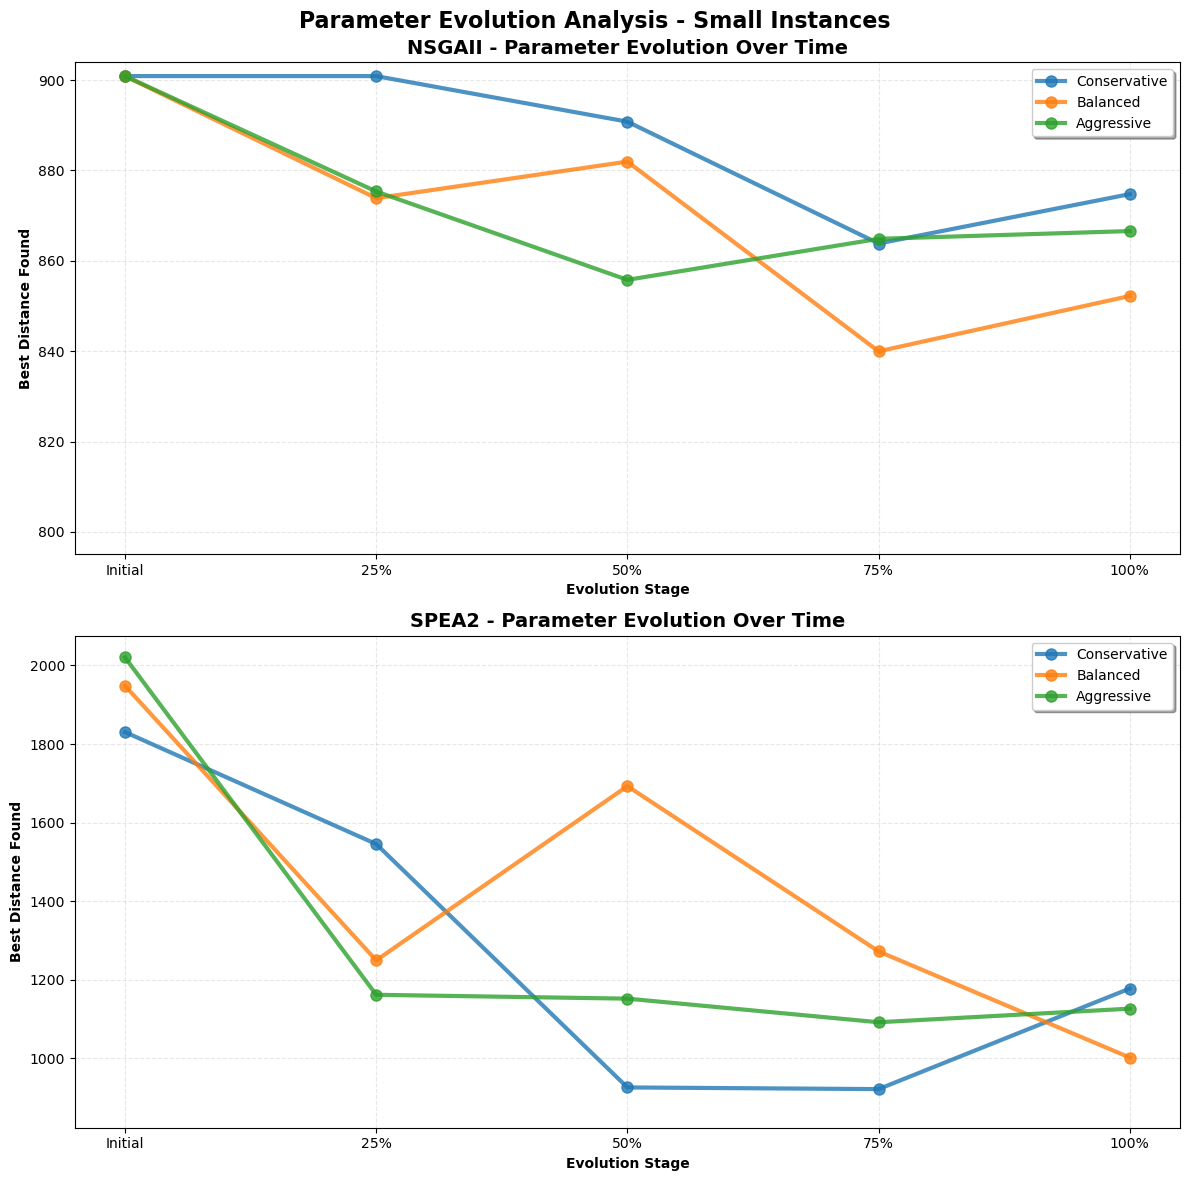


📊 Analyzing Medium Instance Group
📁 Using instances: ['Medium1', 'Medium2']

🔬 NSGAII Evolution Analysis for Medium:
  📈 Conservative... ✅
  📈 Balanced... ✅
  📈 Aggressive... ✅

🔬 SPEA2 Evolution Analysis for Medium:
  📈 Conservative... ✅
  📈 Balanced... ✅
  📈 Aggressive... ✅

📊 Creating Evolution Analysis for Medium Instances...


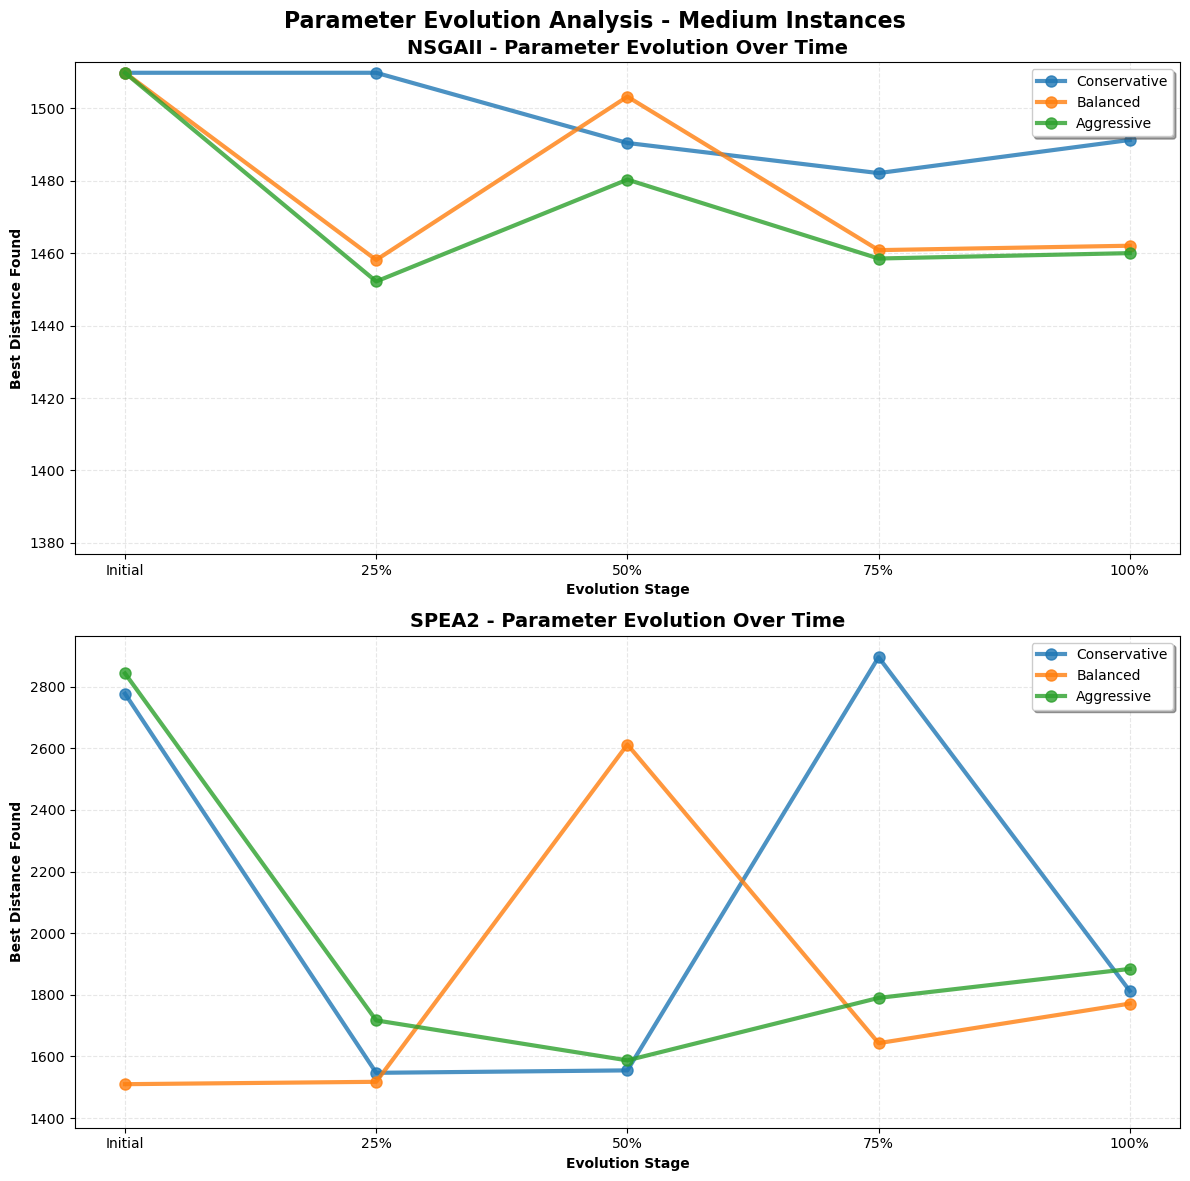


📊 Analyzing Large Instance Group
📁 Using instances: ['Large1', 'Large2']

🔬 NSGAII Evolution Analysis for Large:
  📈 Conservative... ✅
  📈 Balanced... ✅
  📈 Aggressive... ✅

🔬 SPEA2 Evolution Analysis for Large:
  📈 Conservative... ✅
  📈 Balanced... ✅
  📈 Aggressive... ✅

📊 Creating Evolution Analysis for Large Instances...


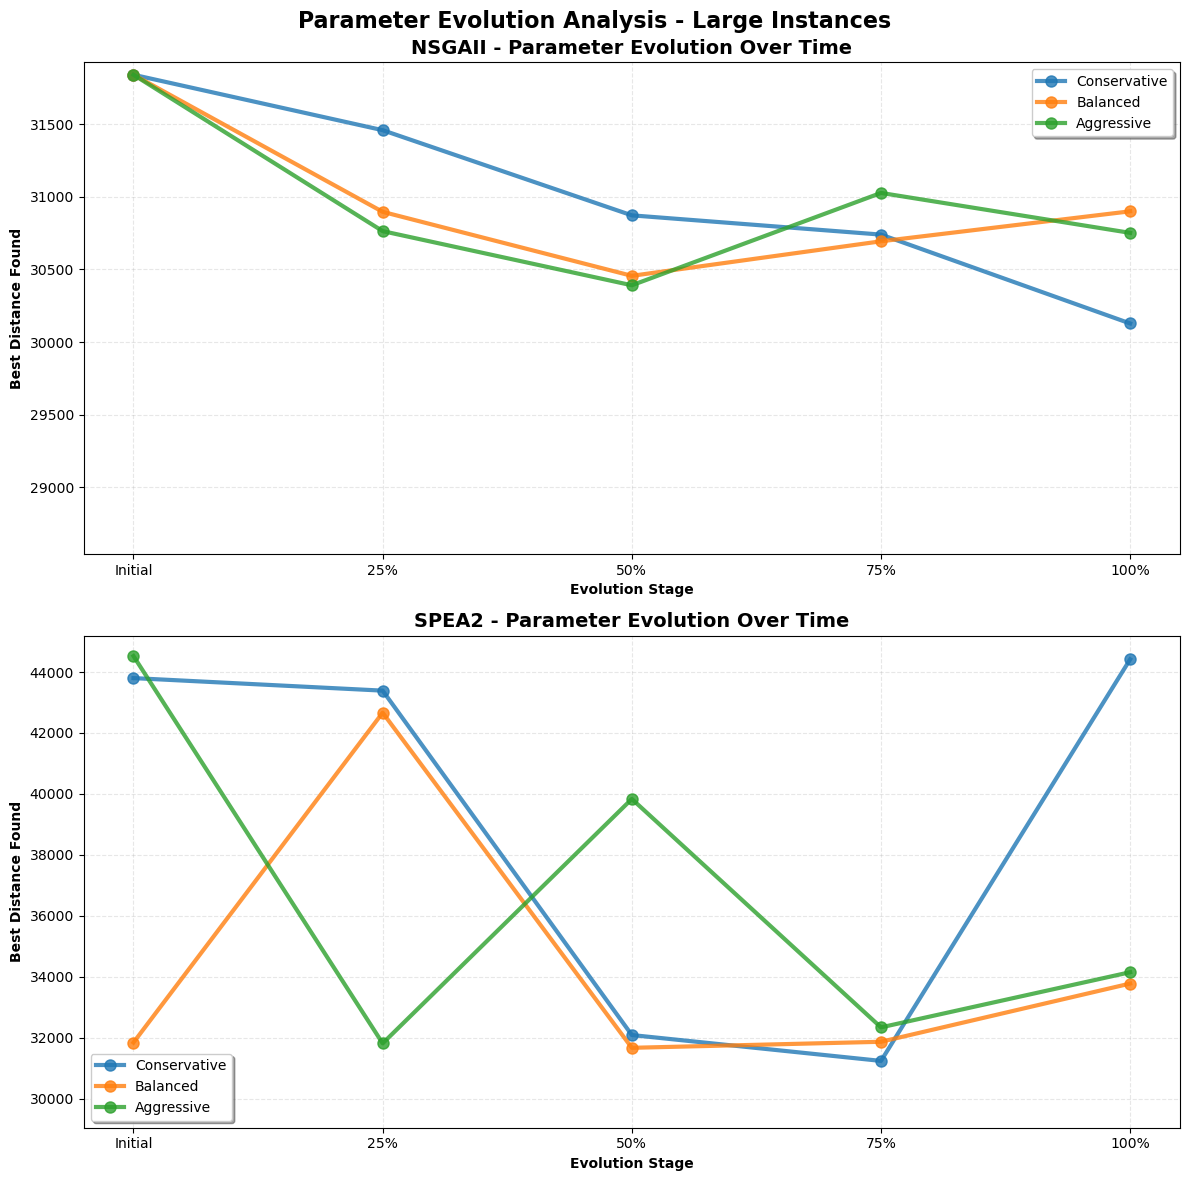

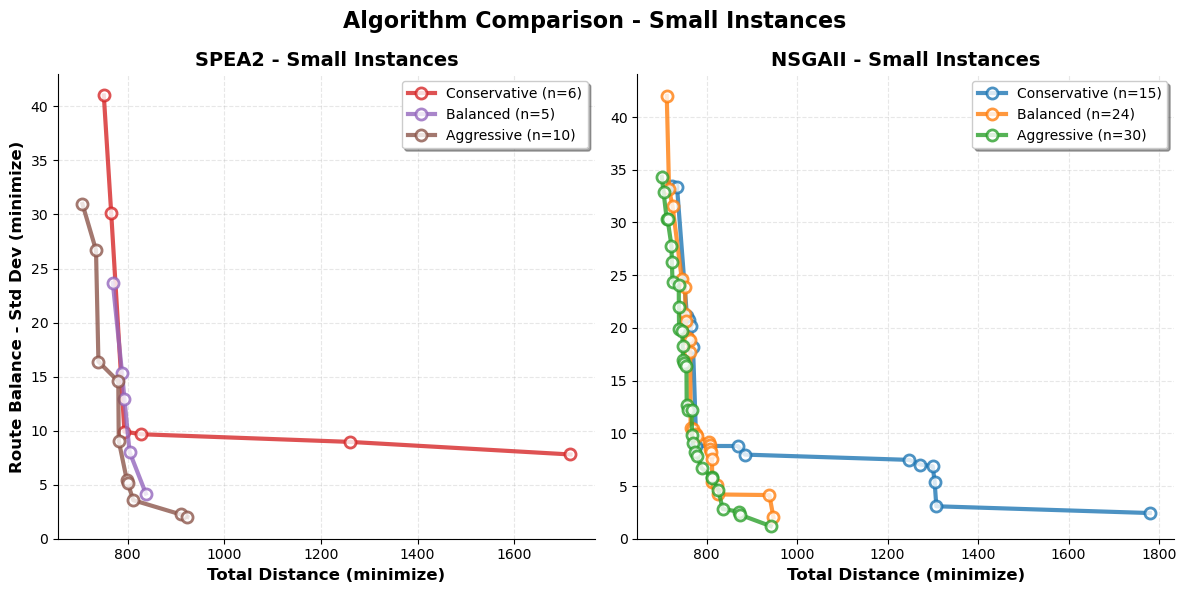

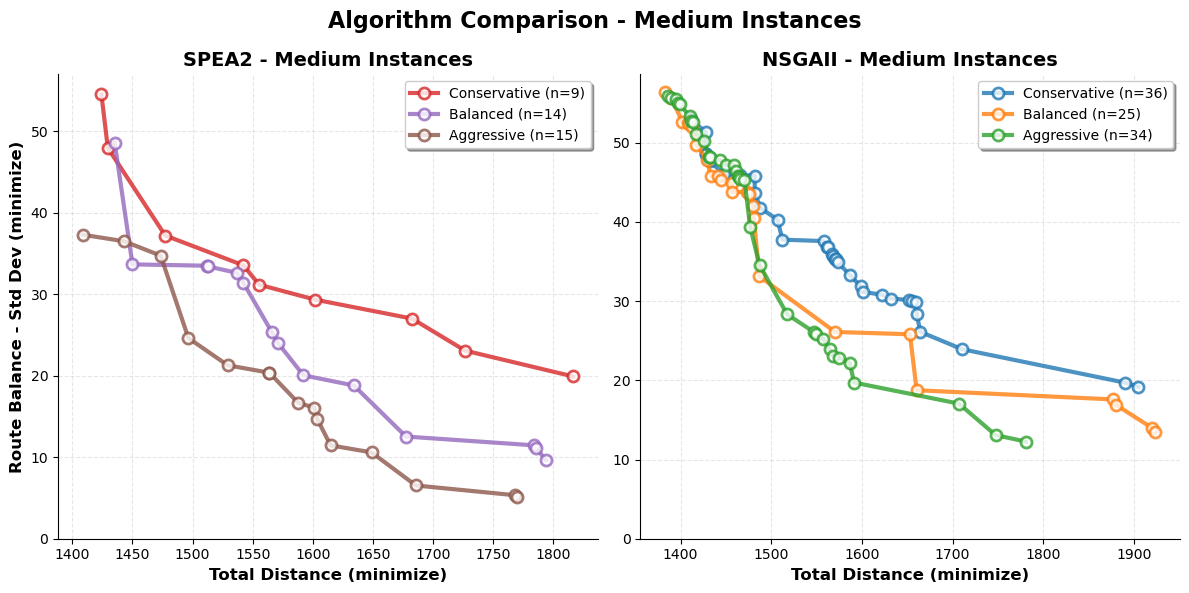

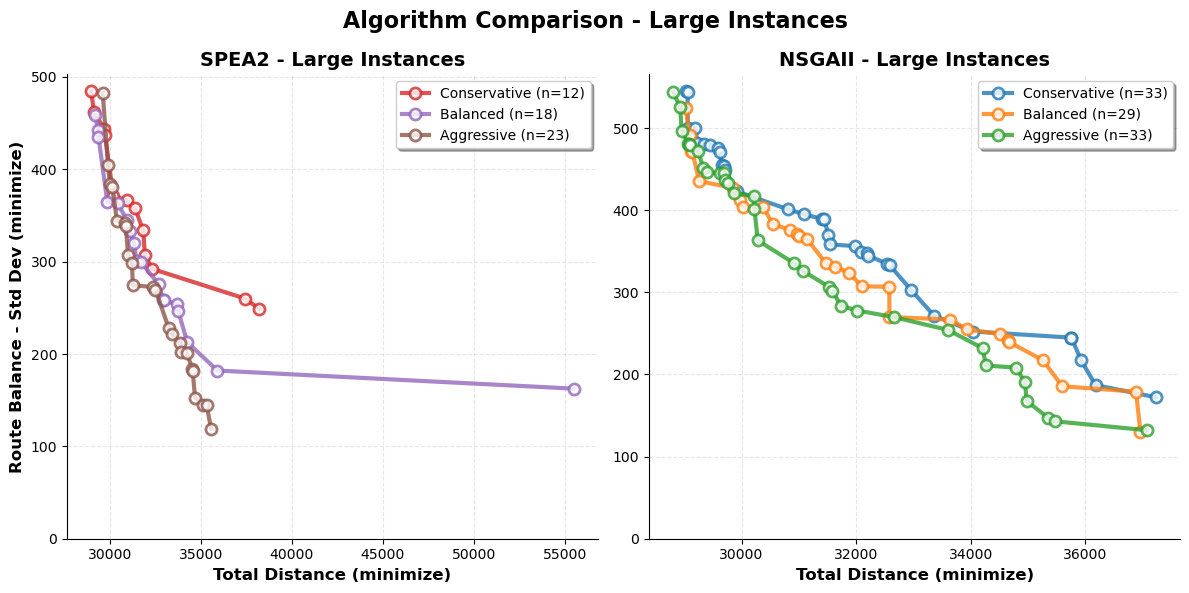

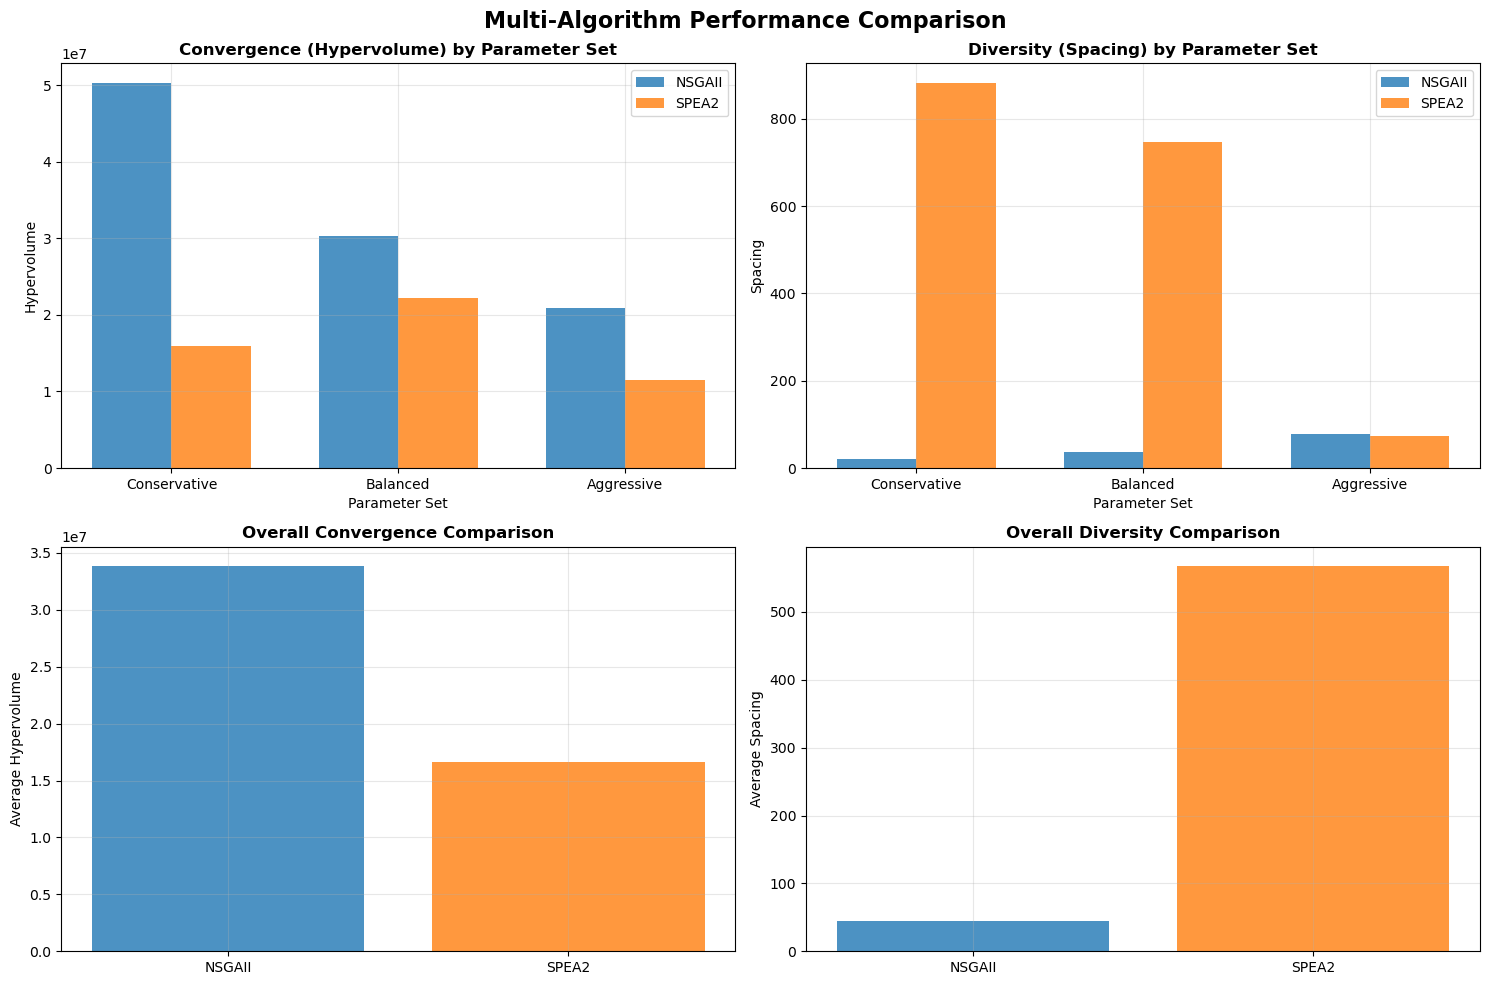

In [127]:
def create_evolution_progression_plots(evolution_results, instance_name):
    """
    Create line plots showing how each parameter evolves over time.
    """
    param_names = ['Conservative', 'Balanced', 'Aggressive']  # Parameter sets
    algo_names = list(evolution_results.keys())  # Algorithm names

    # One subplot per algorithm
    fig, axes = plt.subplots(len(algo_names), 1, figsize=(12, 6 * len(algo_names)))
    if len(algo_names) == 1:
        axes = [axes]

    colors = {'Conservative': '#1f77b4', 'Balanced': '#ff7f0e', 'Aggressive': '#2ca02c'}  # Color map

    for algo_idx, algo_name in enumerate(algo_names):
        ax = axes[algo_idx]
        for param_name in param_names:
            if param_name in evolution_results[algo_name]:
                data = evolution_results[algo_name][param_name]
                if data['best_distances'] and len(data['best_distances']) > 1:
                    stages = data['stages']
                    distances = data['best_distances']
                    # Plot line for parameter set
                    ax.plot(
                        stages, distances, 'o-',
                        color=colors[param_name], linewidth=3, markersize=8,
                        label=param_name, alpha=0.8
                    )
                    # (Removed: % improvement annotation)
        ax.set_title(f'{algo_name} - Parameter Evolution Over Time', fontweight='bold', fontsize=14)
        ax.set_xlabel('Evolution Stage', fontweight='bold')
        ax.set_ylabel('Best Distance Found', fontweight='bold')
        ax.legend(frameon=True, fancybox=True, shadow=True)
        ax.grid(True, alpha=0.3, linestyle='--')
        if ax.get_ylim()[0] > 0:
            ax.set_ylim(bottom=ax.get_ylim()[0] * 0.95)
    plt.suptitle(f'Parameter Evolution Analysis - {instance_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def analyze_parameter_evolution_combined(moea_classes, instance_files, param_sets, data_cache):
    """
    Analyze parameter evolution for combined instance groups and plot progression.
    """
    print("\n🔄 PARAMETER EVOLUTION STAGE ANALYSIS - COMBINED INSTANCES")
    print("=" * 70)
    instance_groups = {
        'Small': [('Small1', 'data/Small.vrp'), ('Small2', 'data/Small2.vrp')],
        'Medium': [('Medium1', 'data/Medium.vrp'), ('Medium2', 'data/Medium2.vrp')],
        'Large': [('Large1', 'data/Large.vrp'), ('Large2', 'data/Large2.vrp')]
    }
    for group_name, group_instances in instance_groups.items():
        print(f"\n📊 Analyzing {group_name} Instance Group")
        print("=" * 50)
        available_instances = [(n, f) for n, f in group_instances if f in data_cache]
        if not available_instances:
            print(f"❌ No cached data available for {group_name} instances")
            continue
        print(f"📁 Using instances: {[name for name, _ in available_instances]}")
        group_evolution_results = {}
        for algo_name, algo_class in moea_classes:
            group_evolution_results[algo_name] = {}
            print(f"\n🔬 {algo_name} Evolution Analysis for {group_name}:")
            for params in param_sets:
                param_name = params["name"]
                print(f"  📈 {param_name}...", end=" ")
                combined_best_distances = []
                try:
                    progress_data = {
                        'stages': ['Initial', '25%', '50%', '75%', '100%'],
                        'generations': [0, params['generations']//4, params['generations']//2, 3*params['generations']//4, params['generations']],
                        'pareto_sizes': [],
                        'best_distances': []
                    }
                    for inst_name, inst_file in available_instances:
                        data = data_cache[inst_file]
                        instance_distances = []
                        for stage_gen in progress_data['generations']:
                            test_alg = algo_class(
                                data=data,
                                pop_size=params['pop_size'],
                                generations=max(1, stage_gen),
                                crossover_rate=params['crossover_rate'],
                                mutation_rate=params['mutation_rate']
                            )
                            final_pop = test_alg.run()
                            if hasattr(test_alg, 'fast_non_dominated_sort'):
                                test_alg.fast_non_dominated_sort(final_pop)
                                pareto_front = [sol for sol in final_pop if sol.get('rank') == 1]
                            else:
                                pareto_front = final_pop[:len(final_pop)//4]
                            if pareto_front:
                                distances = [ind['objectives'][0] for ind in pareto_front]
                                instance_distances.append(min(distances))
                            else:
                                instance_distances.append(float('inf'))
                        combined_best_distances.append(instance_distances)
                    if combined_best_distances:
                        avg_distances = []
                        for stage_idx in range(len(progress_data['generations'])):
                            stage_distances = [inst_dist[stage_idx] for inst_dist in combined_best_distances if stage_idx < len(inst_dist) and inst_dist[stage_idx] != float('inf')]
                            if stage_distances:
                                avg_distances.append(sum(stage_distances) / len(stage_distances))
                            else:
                                avg_distances.append(0)
                        progress_data['best_distances'] = avg_distances
                        progress_data['pareto_sizes'] = [1] * len(avg_distances)
                    group_evolution_results[algo_name][param_name] = progress_data
                    print("✅")
                except Exception as e:
                    print(f"❌ Error: {str(e)[:30]}...")
                    continue
        if group_evolution_results:
            print(f"\n📊 Creating Evolution Analysis for {group_name} Instances...")
            create_evolution_progression_plots(group_evolution_results, f"{group_name} Instances")

def display_results_assignment_format(results):
    """
    Print the comprehensive results table for Assignment 2.
    """
    print("\n" + "="*130)
    print("MULTI-OBJECTIVE VRP ALGORITHM COMPARISON - Assignment 2 Results")
    print("="*130)
    print(f"{'Algorithm':<8} {'Instance':<9} {'Parameter':<12} {'PF/Total':<9} {'Best Dist':<10} {'Best Bal':<9} {'Convergence':<11} {'Diversity':<10} {'Time(s)':<10}")
    print("-" * 130)
    nsga_results = [r for r in results if r['Algorithm'] == 'NSGAII']
    spea_results = [r for r in results if r['Algorithm'] == 'SPEA2']
    if nsga_results:
        print("NSGA-II Results:")
        print("-" * 130)
        for r in nsga_results:
            div_str = f"{r['Diversity']:.3f}" if r['Diversity'] > 0 else "N/A"
            pf_ratio = f"{r['Front_Size']}/{r['Total_Solutions']}"
            time_str = f"{r['Time']:.3f}±{r.get('Time_Std', 0):.3f}"
            print(f"{'NSGA-II':<8} {r['Instance']:<9} {r['Parameter']:<12} {pf_ratio:<9} "
                  f"{r['Best_Distance']:<10.1f} {r['Best_Balance']:<9.2f} "
                  f"{r['Convergence']:<11.0f} {div_str:<10} {time_str:<10}")
    print("-" * 130)
    if spea_results:
        print("SPEA2 Results:")
        print("-" * 130)
        for r in spea_results:
            div_str = f"{r['Diversity']:.3f}" if r['Diversity'] > 0 else "N/A"
            pf_ratio = f"{r['Front_Size']}/{r['Total_Solutions']}"
            time_str = f"{r['Time']:.3f}±{r.get('Time_Std', 0):.3f}"
            print(f"{'SPEA2':<8} {r['Instance']:<9} {r['Parameter']:<12} {pf_ratio:<9} "
                  f"{r['Best_Distance']:<10.1f} {r['Best_Balance']:<9.2f} "
                  f"{r['Convergence']:<11.0f} {div_str:<10} {time_str:<10}")
    print("="*130)

def run_multi_algorithm_experiment(moea_classes, instance_files, param_sets, num_runs=5):
    """
    Run the MOEA experiment and print only the results table and plots.
    """
    print("MULTI-ALGORITHM MOEA EXPERIMENT - Assignment 2")
    print("=" * 60)
    results = []
    pareto_fronts = {}
    all_solutions_dict = {}
    data_cache = {}
    for algo_name, algo_class in moea_classes:
        print(f"\n🔬 Testing Algorithm: {algo_name}")
        print("=" * 40)
        for params in param_sets:
            param_name = params["name"]
            print(f"\n📊 Parameter Set: {param_name}")
            for inst_name, inst_file in instance_files:
                print(f"  📁 {inst_name}...", end=" ", flush=True)
                if inst_file not in data_cache:
                    try:
                        data_cache[inst_file] = parse_vrp_file(inst_file)
                        print(f"(loaded)", end=" ")
                    except Exception as e:
                        print(f"❌ Error loading {inst_file}: {e}")
                        continue
                data = data_cache[inst_file]
                all_run_solutions = []
                run_times = []
                successful_runs = 0
                for run in range(1, num_runs + 1):
                    try:
                        random.seed(run * 456)
                        np.random.seed(run * 456)
                        algorithm = algo_class(
                            data=data,
                            pop_size=params['pop_size'],
                            generations=params['generations'],
                            crossover_rate=params['crossover_rate'],
                            mutation_rate=params['mutation_rate']
                        )
                        start_time = time.time()
                        final_pop = algorithm.run()
                        run_time = time.time() - start_time
                        run_times.append(run_time)
                        all_run_solutions.extend(final_pop)
                        successful_runs += 1
                    except Exception as e:
                        print(f"❌ Run {run} failed: {str(e)[:50]}...")
                        continue
                if all_run_solutions and successful_runs > 0:
                    temp_nsga = NSGAII(data=data, pop_size=10, generations=1)
                    temp_nsga.fast_non_dominated_sort(all_run_solutions)
                    pareto_front = [sol for sol in all_run_solutions if sol.get('rank') == 1]
                    pareto_front.sort(key=lambda x: x['objectives'][0])
                    key = f"{inst_name}_{param_name}_{algo_name}"
                    pareto_fronts[key] = pareto_front
                    all_solutions_dict[key] = all_run_solutions
                    convergence, diversity = calculate_metrics(pareto_front)
                    mean_time = np.mean(run_times)
                    std_time = np.std(run_times) if len(run_times) > 1 else 0
                    results.append({
                        'Algorithm': algo_name,
                        'Instance': inst_name,
                        'Parameter': param_name,
                        'Front_Size': len(pareto_front),
                        'Total_Solutions': len(all_run_solutions),
                        'Best_Distance': min(ind['objectives'][0] for ind in pareto_front),
                        'Best_Balance': min(ind['objectives'][1] for ind in pareto_front),
                        'Convergence': convergence,
                        'Diversity': diversity,
                        'Time': mean_time,
                        'Time_Std': std_time,
                        'Evaluations': params['pop_size'] * params['generations'],
                        'Successful_Runs': successful_runs
                    })
                    print(f"✅ {successful_runs}/{num_runs} runs, {len(pareto_front)}/{len(all_run_solutions)} Pareto solutions")
                else:
                    print(f"❌ All {num_runs} runs failed")
    if results:
        display_results_assignment_format(results)
        analyze_parameter_evolution_combined(moea_classes, instance_files, param_sets, data_cache)
        plot_algorithm_comparison(pareto_fronts)
        plot_metrics_comparison(pareto_fronts)
    else:
        print("\n❌ No results to display - all experiments failed!")
    return results, pareto_fronts, all_solutions_dict

def calculate_metrics(pareto_front):
    """
    Calculate convergence and diversity metrics for Pareto front quality assessment.
    """
    if not pareto_front or len(pareto_front) < 2:
        return 0, 0
    obj1 = [ind['objectives'][0] for ind in pareto_front]
    obj2 = [ind['objectives'][1] for ind in pareto_front]
    ref_point = [max(obj1) * 1.1, max(obj2) * 1.1]
    convergence = sum((ref_point[0] - o1) * (ref_point[1] - o2) for o1, o2 in zip(obj1, obj2))
    if len(pareto_front) < 3:
        diversity = 0
    else:
        distances = []
        for i, ind1 in enumerate(pareto_front):
            min_dist = min(((ind1['objectives'][0] - ind2['objectives'][0])**2 +
                           (ind1['objectives'][1] - ind2['objectives'][1])**2)**0.5
                          for j, ind2 in enumerate(pareto_front) if i != j)
            distances.append(min_dist)
        diversity = np.std(distances)
    return convergence, diversity

def plot_algorithm_comparison(pareto_fronts):
    """
    Generate algorithm comparison plots across different instance sizes.
    """
    algo_colors = {
        'NSGAII': {'Conservative': '#1f77b4', 'Balanced': '#ff7f0e', 'Aggressive': '#2ca02c'},
        'SPEA2': {'Conservative': '#d62728', 'Balanced': '#9467bd', 'Aggressive': '#8c564b'}
    }
    groups = ['Small', 'Medium', 'Large']
    algorithms = [algo for algo in set(key.split('_')[2] for key in pareto_fronts.keys()) if algo in ['NSGAII', 'SPEA2']]
    for group in groups:
        group_keys = [key for key in pareto_fronts.keys() if pareto_fronts[key] and any(group.lower() in part.lower() for part in key.split('_'))]
        if len(group_keys) == 0:
            continue
        fig, axes = plt.subplots(1, len(algorithms) if len(algorithms) > 1 else 1, figsize=(6 * max(len(algorithms), 1), 6))
        if len(algorithms) == 1:
            axes = [axes]
        for algo_idx, algorithm in enumerate(algorithms):
            ax = axes[algo_idx] if len(algorithms) > 1 else axes[0]
            colors = algo_colors.get(algorithm, {'Conservative': '#888888', 'Balanced': '#999999', 'Aggressive': '#aaaaaa'})
            for param in ['Conservative', 'Balanced', 'Aggressive']:
                points = []
                for key, front in pareto_fronts.items():
                    if front and algorithm in key and param in key and any(group.lower() in part.lower() for part in key.split('_')):
                        points.extend([(ind['objectives'][0], ind['objectives'][1]) for ind in front])
                if len(points) < 1:
                    continue
                points = sorted(set(points))
                pareto_points = []
                for i, (x1, y1) in enumerate(points):
                    dominated = any(x2 <= x1 and y2 <= y1 and (x2 < x1 or y2 < y1) for j, (x2, y2) in enumerate(points) if i != j)
                    if not dominated:
                        pareto_points.append((x1, y1))
                pareto_points.sort()
                if len(pareto_points) >= 1:
                    x_vals = [p[0] for p in pareto_points]
                    y_vals = [p[1] for p in pareto_points]
                    if len(pareto_points) == 1:
                        ax.scatter(x_vals, y_vals, color=colors[param], s=100, alpha=0.8, label=f"{param} (n={len(pareto_points)})", edgecolors='white', linewidth=2)
                    else:
                        ax.plot(x_vals, y_vals, 'o-', color=colors[param], linewidth=3, markersize=8, alpha=0.8, label=f"{param} (n={len(pareto_points)})", markerfacecolor='white', markeredgewidth=2, markeredgecolor=colors[param])
            ax.set_xlabel("Total Distance (minimize)", fontweight='bold', fontsize=12)
            if algo_idx == 0 or len(algorithms) == 1:
                ax.set_ylabel("Route Balance - Std Dev (minimize)", fontweight='bold', fontsize=12)
            ax.set_title(f"{algorithm} - {group} Instances", fontweight='bold', fontsize=14)
            ax.grid(True, alpha=0.3, linestyle='--')
            ax.set_ylim(bottom=0)
            ax.legend(frameon=True, fancybox=True, shadow=True, loc='upper right')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        plt.suptitle(f"Algorithm Comparison - {group} Instances", fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

def plot_metrics_comparison(pareto_fronts):
    """
    Generate performance metrics comparison plots across algorithms.
    """
    algorithms = sorted(list(set(key.split('_')[2] for key in pareto_fronts.keys())))
    algo_metrics = {}
    for algo in algorithms:
        algo_metrics[algo] = {}
        for key, front in pareto_fronts.items():
            if front and algo in key:
                parts = key.split('_')
                param = parts[1] if len(parts) > 1 else 'Unknown'
                if param not in algo_metrics[algo]:
                    algo_metrics[algo][param] = {'conv': [], 'div': []}
                conv, div = calculate_metrics(front)
                algo_metrics[algo][param]['conv'].append(conv)
                algo_metrics[algo][param]['div'].append(div if div > 0 else 0)
    params = ['Conservative', 'Balanced', 'Aggressive']
    if len(algorithms) > 1:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        ax3, ax4 = None, None
    algo_colors_simple = {'NSGAII': '#1f77b4', 'SPEA2': '#ff7f0e'}
    x = np.arange(len(params))
    width = 0.35 if len(algorithms) > 1 else 0.6
    for i, algo in enumerate(algorithms):
        if algo in algo_metrics:
            conv_means = [np.mean(algo_metrics[algo][p]['conv']) if p in algo_metrics[algo] else 0 for p in params]
            ax1.bar(x + i*width if len(algorithms) > 1 else x, conv_means, width, label=algo, color=algo_colors_simple.get(algo, '#888888'), alpha=0.8)
    ax1.set_title('Convergence (Hypervolume) by Parameter Set', fontweight='bold')
    ax1.set_xlabel('Parameter Set')
    ax1.set_ylabel('Hypervolume')
    ax1.set_xticks(x + width/2 if len(algorithms) > 1 else x)
    ax1.set_xticklabels(params)
    if len(algorithms) > 1:
        ax1.legend()
    ax1.grid(True, alpha=0.3)
    for i, algo in enumerate(algorithms):
        if algo in algo_metrics:
            div_means = [np.mean(algo_metrics[algo][p]['div']) if p in algo_metrics[algo] else 0 for p in params]
            ax2.bar(x + i*width if len(algorithms) > 1 else x, div_means, width, label=algo, color=algo_colors_simple.get(algo, '#888888'), alpha=0.8)
    ax2.set_title('Diversity (Spacing) by Parameter Set', fontweight='bold')
    ax2.set_xlabel('Parameter Set')
    ax2.set_ylabel('Spacing')
    ax2.set_xticks(x + width/2 if len(algorithms) > 1 else x)
    ax2.set_xticklabels(params)
    if len(algorithms) > 1:
        ax2.legend()
    ax2.grid(True, alpha=0.3)
    if len(algorithms) > 1 and ax3 is not None and ax4 is not None:
        algo_conv_overall = []
        algo_div_overall = []
        for algo in algorithms:
            if algo in algo_metrics:
                all_conv = [v for param_data in algo_metrics[algo].values() for v in param_data['conv']]
                all_div = [v for param_data in algo_metrics[algo].values() for v in param_data['div']]
                algo_conv_overall.append(np.mean(all_conv) if all_conv else 0)
                algo_div_overall.append(np.mean(all_div) if all_div else 0)
            else:
                algo_conv_overall.append(0)
                algo_div_overall.append(0)
        ax3.bar(algorithms, algo_conv_overall, color=[algo_colors_simple.get(a, '#888888') for a in algorithms], alpha=0.8)
        ax3.set_title('Overall Convergence Comparison', fontweight='bold')
        ax3.set_ylabel('Average Hypervolume')
        ax3.grid(True, alpha=0.3)
        ax4.bar(algorithms, algo_div_overall, color=[algo_colors_simple.get(a, '#888888') for a in algorithms], alpha=0.8)
        ax4.set_title('Overall Diversity Comparison', fontweight='bold')
        ax4.set_ylabel('Average Spacing')
        ax4.grid(True, alpha=0.3)
        plt.suptitle("Multi-Algorithm Performance Comparison", fontsize=16, fontweight='bold')
    else:
        plt.suptitle("NSGA-II Performance Metrics", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# --- Streamlined Experimental Configuration ---

moea_classes = [
    ("NSGAII", NSGAII),
    ("SPEA2", SPEA2)
]

instance_files = [
    ("Small1", "data/Small.vrp"),
    ("Small2", "data/Small2.vrp"),
    ("Medium1", "data/Medium.vrp"),
    ("Medium2", "data/Medium2.vrp"),
    ("Large1", "data/Large.vrp"),
    ("Large2", "data/Large2.vrp")
]

param_sets = [
    {"name": "Conservative", "pop_size": 60, "generations": 25, "crossover_rate": 0.5, "mutation_rate": 0.05},
    {"name": "Balanced", "pop_size": 40, "generations": 40, "crossover_rate": 0.8, "mutation_rate": 0.2},
    {"name": "Aggressive", "pop_size": 25, "generations": 80, "crossover_rate": 0.95, "mutation_rate": 0.5}
]

# Run the experiment and show only the table and plots
results, pareto_fronts, all_solutions = run_multi_algorithm_experiment(
    moea_classes,
    instance_files,
    param_sets,
    num_runs=20
)